# COMP 4531 Final Project - Winter 2024

Team: Corey Munk and Kurt Meyer

Topic: Image Classification using the CIFAR-100 data set





Google forms to fill out: https://docs.google.com/forms/d/e/1FAIpQLSc4jIBcai4vrnZs1AWR9Wnnudwp_HvlDbdSGrVPxY6BsFrvFw/viewform

EDA:
- count of samples by group? enough samples to train?

Project Overview:
- simple model to compare? --no because you cant use linear reg for image classification?
- find model that has been published to act as upper bound? --mobilenetv2 or EfficientNetB0?

In [56]:
import numpy as np 
from matplotlib import pyplot as plt
from keras.datasets import cifar100
from keras.utils import to_categorical
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [57]:
# Load CIFAR-100 data and create train test splits
(X, Y), (_, _) = cifar100.load_data() 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=123, shuffle=True)


In [58]:
# Create a random classifier Dummy classifier
dummy_rand = DummyClassifier(strategy="uniform", random_state=123)

# train the dummy classifier
dummy_rand.fit(X_train, Y_train)

# make predicitons
dummy_rand_preds = dummy_rand.predict(X_test)

# calc accuracy
baseline_accuracy_dummyrand = accuracy_score(Y_test, dummy_rand_preds)

print(f"Baseline accuracy for Random Dummy Classifier: {baseline_accuracy_dummyrand * 100}%")

Baseline accuracy for Random Dummy Classifier: 0.91%


In [59]:
# Vectorize and normalize input images
X_train = (X_train.reshape(X_train.shape[0], -1).T) / 255
X_test = (X_test.reshape(X_test.shape[0], -1).T) / 255

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", Y_train.shape)
print("y_test:", Y_test.shape)

X_train: (3072, 40000)
X_test: (3072, 10000)
y_train: (40000, 1)
y_test: (10000, 1)


In [60]:
input_size = 32*32*3 # each image is 32x32 in size with three color channels
hidden_size = 15 # define number of hidden neurons
output_size = 100 # there are 100 classes

def init_params():

    # input layer
    W1 = np.random.uniform(low = -0.5, high = 0.5, size=(hidden_size, input_size)) # 30x3072
    b1 = np.random.uniform(low = -0.5, high = 0.5, size=(hidden_size, 1)) # 30x1

    # hidden layer
    W2 = np.random.uniform(low = -0.5, high = 0.5, size=(output_size, hidden_size)) # 100x30
    b2 = np.random.uniform(low = -0.5, high = 0.5, size=(output_size, 1)) # 100x1
    return W1, b1, W2, b2

In [61]:
# Activation function to implement non linearity

a = .02

def LeakyReLU(Z, a=a):
    return np.where(Z>0, Z, a*Z)

def LeakyReLU_deriv(Z, a=a):
    return np.where(Z > 0, 1, a)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0, keepdims=True)
    return A

In [62]:
def forward_prop(W1, b1, W2, b2, X):

    Z1 = np.dot(W1, X) + b1 # the input layer takes in X applies the weights and bias to it via linear operations

    A1 = LeakyReLU(Z1) # activation function takes in Z1 which is the output from the linear opeerations

    Z2 = np.dot(W2, A1) + b2 # the hidden layer takes in A1 from the activation funciton and again applies the weights and bias to it via linear operations

    A2 = softmax(Z2) # finally the softmax function takes in Z2 from the hidden layer and ensures that the sum of the probabilities are equal to one and can thus be compared apples to apples.

    return Z1, A1, Z2, A2

In [63]:
# This one hot function is to convert a numeric number into a one-hot vector
def one_hot(Y):
    num_samples = len(Y) # total rows of image data 
    num_labels = output_size # possible labels
    one_hot_Y = np.zeros((num_labels, num_samples)) # create an array to store the one hot encoded label for each image

    for i in range(num_samples): # loop through each image and encode its true label
        one_hot_Y[Y[i], i] = 1

    return one_hot_Y

# Now performing the backward propagation
# Each function is only one line, but lots of Calculus behind 
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1]
    
    dZ2 = A2 - one_hot(Y)
    dW2 = np.dot(dZ2, A1.T) * (1/m) 
    db2 = np.sum(dZ2, axis=1, keepdims=True) * (1/m) 

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * LeakyReLU_deriv(Z1)
    dW1 = np.dot(dZ1, X.T) * (1/m) 
    db1 = np.sum(dZ1, axis=1, keepdims=True) * (1/m) 

    return dW1, db1, dW2, db2

# Finally, we are ready to update the parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):

    W1 = W1 - (alpha * dW1)
    
    b1 = b1 - (alpha * db1)

    W2 = W2 - (alpha * dW2)

    b2 = b2 - (alpha * db2)

    return W1, b1, W2, b2


In [64]:
# Gradient Descent

def get_predictions(A2):
    return np.argmax(A2, axis=0) # returns the label that was given the highest propability by the softmax function

# We also want to have a simple function to compute the accuracy. Notice that "predictions" and "Y" are the same shape
def get_accuracy(predictions, Y):
    return np.mean(predictions == Y) * 100 # compares the predictions to the true labels and returns the accuracy

def get_loss(A2, Y):
    m = Y.shape[1]
    log_prob = -np.log(A2[Y, np.arange(m)])
    loss = np.sum(log_prob) / m
    return loss

# Finally, we are ready to implement gradient descent
def gradient_descent(X, Y, alpha, iterations):

    W1, b1, W2, b2 = init_params()

    for i in range(iterations):
     
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)

        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            print("Iteration: ", i)
            print("Loss:", get_loss(A2, Y))
            predictions = get_predictions(A2)
            print("Accuracy", get_accuracy(predictions, Y))
            
    return W1, b1, W2, b2

In [65]:
alpha = .1
epochs = 500

W1, b1, W2, b2 = gradient_descent(X_train, Y_train, alpha, epochs)

Iteration:  0
Loss: 292268.92356873705
Accuracy 0.99328275
Iteration:  10
Loss: 186088.4818545613
Accuracy 1.0129081875
Iteration:  20
Loss: 186039.86774401966
Accuracy 1.013284
Iteration:  30
Loss: 185985.8165152687
Accuracy 1.0132755
Iteration:  40
Loss: 185930.09144428198
Accuracy 1.013155625
Iteration:  50
Loss: 185874.22437567794
Accuracy 1.012991125
Iteration:  60
Loss: 185819.47840316856
Accuracy 1.0127866875
Iteration:  70
Loss: 185766.74391911837
Accuracy 1.0126095
Iteration:  80
Loss: 185716.01687275973
Accuracy 1.012451875
Iteration:  90
Loss: 185667.2279368917
Accuracy 1.0122994374999998
Iteration:  100
Loss: 185620.18036412366
Accuracy 1.012191125
Iteration:  110
Loss: 185574.84305383347
Accuracy 1.012109125
Iteration:  120
Loss: 185531.26760919765
Accuracy 1.0120420625
Iteration:  130
Loss: 185489.45368781645
Accuracy 1.011991125
Iteration:  140
Loss: 185449.2427566665
Accuracy 1.011947375
Iteration:  150
Loss: 185410.58672668517
Accuracy 1.0118976874999999
Iteration:  16

In [66]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

dev_predictions = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_test)

0.981456

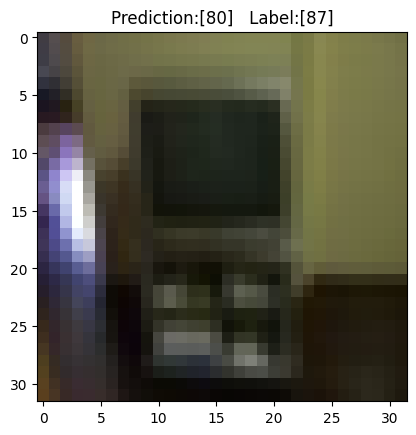

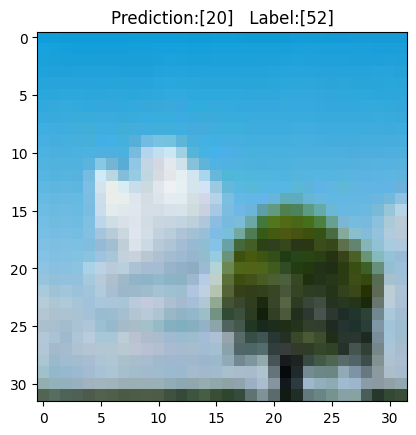

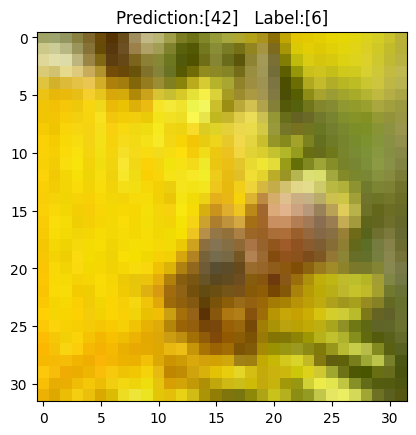

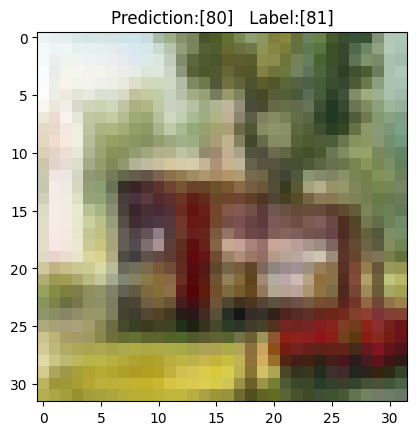

In [67]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    # print("Prediction: ", prediction)
    # print("Label: ", label)
    
    current_image = ( current_image.reshape((32, 32, 3)) * 255 ).clip(0,255).astype(int)
    plt.imshow(current_image, interpolation='nearest')
    plt.title(f"Prediction:{prediction}   Label:{label}")
    plt.show()
    
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(50, W1, b1, W2, b2)

In [68]:
index_to_print = 0  # Choose the index of the image you want to print
vector_representation = X_train[:, index_to_print]

print(f"Vector representation of X_train[{index_to_print}]:")
print(vector_representation)

Vector representation of X_train[0]:
[0.25098039 0.23529412 0.2627451  ... 0.11764706 0.09803922 0.05490196]
